<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Required Libraries and Modules</h2>
</div>

**Note: This notebook is run in Paperspace platform**

In [1]:
!pip install transformers
!pip install imblearn
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 24.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.2/763.2 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 24.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 183.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 24.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895261 sha256=4baefdeafb9267781d20b0d2346ba5bf6f76f8d9e102b83a46e5050cd978ded7
  Stored in directory: /tmp/pip-ephem-wheel-cache-xvlrvknb/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 24.3 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,  classification_report
from imblearn.under_sampling import RandomUnderSampler

import torch
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_52/1605486461.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Clean Text Data</h2>
</div>

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/datasets/data/bully_data_clean_with_stopword_short.csv', encoding='utf8')
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['role','text_check']]

def convert_role_label(x):
    if x == "None":
        return int(0)
    elif x == "Harasser":
        return int(1)
    elif x == "Victim":
        return int(2)
    elif x == "Bystander_defender":
        return int(3)
    elif x == "Bystander_assistant":
        return int(1)

bully_data_cleaned['label'] = bully_data_cleaned['role'].progress_apply(lambda x: convert_role_label(x)).astype(int)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   role    112247 non-null  object
 1   text    112247 non-null  object
 2   label   112247 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      3596
2      1354
3       425
Name: label, dtype: int64

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define pretrained tokenizer and model</h2>
</div>

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define pretrained tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set Seed for reproducibility
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preprocess data</h2>
</div>

In [7]:
##############################
# Data: Text Input and Label #
##############################
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


########################
# Create torch dataset #
########################
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


#############################
# Define Trainer parameters #
#############################
average_method = 'macro'
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average=average_method)
    precision = precision_score(y_true=labels, y_pred=pred, average=average_method)
    f1 = f1_score(y_true=labels, y_pred=pred, average=average_method)
    
    recall0 = recall_score(y_true=labels, y_pred=pred, average=None)[0]
    precision0 = precision_score(y_true=labels, y_pred=pred, average=None)[0]
    f10 = f1_score(y_true=labels, y_pred=pred, average=None)[0]
    
    recall1 = recall_score(y_true=labels, y_pred=pred, average=None)[1]
    precision1 = precision_score(y_true=labels, y_pred=pred, average=None)[1]
    f11 = f1_score(y_true=labels, y_pred=pred, average=None)[1]
    
    recall2 = recall_score(y_true=labels, y_pred=pred, average=None)[2]
    precision2 = precision_score(y_true=labels, y_pred=pred, average=None)[2]
    f12 = f1_score(y_true=labels, y_pred=pred, average=None)[2]
    
    recall3 = recall_score(y_true=labels, y_pred=pred, average=None)[3]
    precision3 = precision_score(y_true=labels, y_pred=pred, average=None)[3]
    f13 = f1_score(y_true=labels, y_pred=pred, average=None)[3]

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1,
           "precision_nonbully": precision0, "recall_nonbully": recall0, "f1_nonbully": f10,
           "precision_harasser": precision1, "recall_harasser": recall1, "f1_harasser": f11,
           "precision_victim": precision2, "recall_victim": recall2, "f1_victim": f12,
           "precision_bydefender": precision3, "recall_bydefender": recall3, "f1_bydefender": f13}


#########################
# Plot Confusion Matrix #
#########################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


########################
# Run cross-validation #
########################
def run_cross_validation(model_name='RoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=False):
  
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)

        # Split to train and test set for each fold
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]


        # Obtain undersampled index 
        X_temp = bully_data_cleaned["text"].values
        y_temp = bully_data_cleaned["label"].values

        X_temp_train = X_temp[train] 
        y_temp_train = y_temp[train] 

        resample = RandomUnderSampler(random_state=1127,sampling_strategy={0:33363})
        X_temp_resampled, y_temp_resampled = resample.fit_resample(X_temp_train.reshape(-1,1), y_temp_train)

        resample_index = list(resample.sample_indices_)
        print(len(resample_index))


        # Undersample train set
        X_train_resample = [X_train[i] for i in resample_index]
        y_train_resample = [y_train[i] for i in resample_index]


        # Checking proportion
        print(Counter(y))
        print(Counter(y_train))
        print(Counter(y_temp_resampled))
        print(Counter(y_train_resample))

        
        # Tokenize
        X_train_tokenized = tokenizer(X_train_resample, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train_resample)
        val_dataset = Dataset(X_val_tokenized, y_val)  

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
                output_dir="content/drive/MyDrive/output_" + model_name + "/fold"+str(n_fold),
                evaluation_strategy="epoch",
                save_strategy="epoch",
                #eval_steps=500,
                #per_device_train_batch_size=1,
                #per_device_eval_batch_size=1,
                num_train_epochs=epoch, #1 was okay
                seed=1127,
                load_best_model_at_end=True,
            )
        
        trainer = Trainer(
                  model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  compute_metrics=compute_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
              )
        
        checkpoint_temp = checkpoint
        if n_fold <= 2:
            checkpoint_temp=True
        else:
            checkpoint_temp=False
            
        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Cross Validation (K = 5)</h2>
</div>

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.290800,0.162368,0.949399,0.460820,0.499818,0.476101,0.982348,0.973800,0.978056,0.461698,0.619444,0.529063,0.144330,0.103704,0.120690,0.254902,0.302326,0.276596
2,0.242900,0.162908,0.952160,0.528474,0.570284,0.543114,0.983735,0.973426,0.978553,0.477318,0.672222,0.558247,0.244681,0.170370,0.200873,0.408163,0.465116,0.434783
3,0.167200,0.187208,0.951982,0.539035,0.580654,0.554299,0.983546,0.973239,0.978365,0.469758,0.647222,0.544393,0.310680,0.237037,0.268908,0.392157,0.465116,0.425532
4,0.110800,0.253702,0.949310,0.548094,0.607013,0.573381,0.984228,0.969309,0.976711,0.462151,0.644444,0.538283,0.289474,0.325926,0.306620,0.456522,0.488372,0.471910


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-14325/config.json
Model weights saved i

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.289100,0.139565,0.953051,0.614451,0.632511,0.614487,0.986314,0.971086,0.978641,0.452763,0.705556,0.551574,0.413462,0.318519,0.359833,0.605263,0.534884,0.567901
2,0.215400,0.166848,0.957595,0.646498,0.574030,0.588631,0.984826,0.977730,0.981265,0.509165,0.694444,0.587544,0.330097,0.251852,0.285714,0.761905,0.372093,0.500000
3,0.116600,0.196352,0.956258,0.601075,0.614704,0.601020,0.986921,0.974361,0.980601,0.518072,0.716667,0.601399,0.305556,0.325926,0.315412,0.593750,0.441860,0.506667
4,0.084500,0.243276,0.954477,0.593096,0.624776,0.603901,0.986151,0.972771,0.979415,0.515400,0.697222,0.592680,0.287500,0.340741,0.311864,0.583333,0.488372,0.531646


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-9550/pytorch_model.bin
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-14325/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-14325/pytorc

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.254300,0.146784,0.959109,0.585202,0.632717,0.597856,0.989192,0.976326,0.982717,0.513711,0.780556,0.619625,0.317073,0.192593,0.239631,0.520833,0.581395,0.549451
2,0.183700,0.158420,0.957238,0.572798,0.651121,0.599210,0.989635,0.973800,0.981654,0.501786,0.780556,0.610870,0.326087,0.222222,0.264317,0.473684,0.627907,0.540000
3,0.110000,0.182355,0.960713,0.580130,0.620317,0.597954,0.986816,0.980537,0.983667,0.566820,0.683333,0.619647,0.286885,0.259259,0.272374,0.480000,0.558140,0.516129
4,0.088000,0.212958,0.959198,0.557523,0.644488,0.593682,0.988928,0.977824,0.983344,0.554585,0.705556,0.621027,0.264706,0.266667,0.265683,0.421875,0.627907,0.504673


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-14325/config.json
Model weights saved i

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.230800,0.134130,0.955189,0.591219,0.701617,0.625240,0.993561,0.967344,0.980277,0.473525,0.869444,0.613124,0.438776,0.318519,0.369099,0.459016,0.651163,0.538462
2,0.163200,0.137170,0.966236,0.645544,0.691339,0.663072,0.991482,0.980256,0.985837,0.586345,0.811111,0.680653,0.460870,0.392593,0.424000,0.543478,0.581395,0.561798
3,0.116500,0.170131,0.961069,0.588900,0.715274,0.640850,0.992946,0.974642,0.983709,0.563851,0.797222,0.660529,0.345679,0.414815,0.377104,0.453125,0.674419,0.542056
4,0.072600,0.186919,0.962494,0.586878,0.707849,0.635323,0.992581,0.976420,0.984434,0.578000,0.802778,0.672093,0.356643,0.377778,0.366906,0.420290,0.674419,0.517857


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-14325/config.json
Model weights saved i

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.196900,0.098015,0.971047,0.666408,0.723327,0.691449,0.992355,0.983812,0.988065,0.664459,0.836111,0.740467,0.448819,0.422222,0.435115,0.560000,0.651163,0.602151
2,0.156900,0.129398,0.969443,0.724115,0.713714,0.705470,0.992712,0.981473,0.987061,0.598131,0.888889,0.715084,0.505618,0.333333,0.401786,0.800000,0.651163,0.717949
3,0.102100,0.135293,0.972739,0.688668,0.737912,0.702616,0.991532,0.986058,0.988787,0.669663,0.827778,0.740373,0.543478,0.370370,0.440529,0.550000,0.767442,0.640777


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-14325/config.json
Model weights saved i

### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_DistilBert/fold1/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 19100
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.128800,0.264323,0.948241,0.530906,0.583754,0.551638,0.985338,0.968373,0.976782,0.479592,0.652778,0.552941,0.222798,0.318519,0.262195,0.435897,0.395349,0.414634
6,0.087200,0.304232,0.946815,0.504070,0.621596,0.549929,0.985589,0.966314,0.975856,0.472505,0.644444,0.545241,0.255556,0.340741,0.292063,0.302632,0.534884,0.386555
7,0.051400,0.314969,0.953942,0.559878,0.585127,0.570762,0.982284,0.975391,0.978825,0.512360,0.633333,0.566460,0.290323,0.266667,0.277992,0.454545,0.465116,0.459770


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-33425/config.json
Model weights s

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold2/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.088600,0.242863,0.955546,0.633402,0.651254,0.634701,0.986269,0.974549,0.980374,0.562044,0.641667,0.599222,0.250000,0.407407,0.309859,0.735294,0.581395,0.649351
6,0.060400,0.287275,0.957238,0.589129,0.628600,0.607368,0.985658,0.977449,0.981536,0.540793,0.644444,0.588086,0.274510,0.311111,0.291667,0.555556,0.581395,0.568182
7,0.056900,0.299920,0.954744,0.569106,0.596071,0.579103,0.985993,0.974829,0.980379,0.510684,0.663889,0.577295,0.266234,0.303704,0.283737,0.513514,0.441860,0.475000


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-33425/config.json
Model weights s

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold3/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.075200,0.219756,0.957060,0.557305,0.619166,0.584555,0.988077,0.977075,0.982545,0.562802,0.647222,0.602067,0.238342,0.340741,0.280488,0.440000,0.511628,0.473118
6,0.060500,0.259911,0.957773,0.587309,0.618871,0.600608,0.987524,0.977636,0.982555,0.558140,0.666667,0.607595,0.228571,0.296296,0.258065,0.575000,0.534884,0.554217
7,0.044300,0.277390,0.957416,0.562980,0.654376,0.601811,0.988256,0.976420,0.982303,0.541020,0.677778,0.601726,0.254902,0.288889,0.270833,0.467742,0.674419,0.552381


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-33425/config.json
Model weights s

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold4/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.079100,0.219904,0.955367,0.571535,0.732072,0.632596,0.993657,0.967437,0.980372,0.508418,0.838889,0.633124,0.326923,0.377778,0.350515,0.457143,0.744186,0.566372
6,0.069100,0.204272,0.963653,0.610972,0.696448,0.648591,0.991459,0.977543,0.984452,0.604211,0.797222,0.687425,0.358025,0.429630,0.390572,0.490196,0.581395,0.531915
7,0.048100,0.244732,0.964811,0.619786,0.688216,0.649494,0.990352,0.979695,0.984995,0.601279,0.783333,0.680338,0.396947,0.385185,0.390977,0.490566,0.604651,0.541667


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-33425/config.json
Model weights s

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold5/checkpoint-14325).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
4,0.093700,0.164673,0.970780,0.695784,0.736719,0.714645,0.991704,0.984280,0.987978,0.664352,0.797222,0.724747,0.422535,0.444444,0.433213,0.704545,0.720930,0.712644
5,0.077500,0.191267,0.962762,0.605363,0.755703,0.665666,0.994085,0.974923,0.984410,0.572565,0.800000,0.667439,0.397661,0.503704,0.444444,0.457143,0.744186,0.566372
6,0.039500,0.198751,0.969889,0.672134,0.721435,0.692992,0.991509,0.983438,0.987457,0.644105,0.819444,0.721271,0.440678,0.385185,0.411067,0.612245,0.697674,0.652174


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-19100
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-19100/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-19100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-28650/config.json
Model weights s

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_DistilBert/fold1/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 33425
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.039900,0.366202,0.949310,0.526149,0.601041,0.557672,0.984325,0.969496,0.976854,0.466135,0.650000,0.542923,0.285714,0.296296,0.290909,0.368421,0.488372,0.420000


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold1/checkpoint-4775 (score: 0.16236844658851624).
1it [17:39, 1059.42s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold2/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.026000,0.335926,0.955100,0.582802,0.618904,0.597298,0.986264,0.974174,0.980182,0.508230,0.686111,0.583924,0.286713,0.303704,0.294964,0.550000,0.511628,0.530120


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold2/checkpoint-4775 (score: 0.1395651400089264).
2it [35:17, 1058.40s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold3/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.022700,0.312532,0.957951,0.564358,0.630872,0.593265,0.987144,0.977169,0.982131,0.545652,0.697222,0.612195,0.251908,0.244444,0.248120,0.472727,0.604651,0.530612


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold3/checkpoint-4775 (score: 0.1467844843864441).
3it [53:02, 1061.50s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold4/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.029100,0.278551,0.961960,0.606475,0.700089,0.645932,0.991540,0.976046,0.983732,0.565558,0.802778,0.663605,0.359712,0.370370,0.364964,0.509091,0.651163,0.571429


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold4/checkpoint-4775 (score: 0.13413041830062866).
4it [1:10:38, 1059.34s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold5/checkpoint-28650).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
7,0.026200,0.253626,0.964009,0.639274,0.740623,0.681330,0.994560,0.975110,0.984739,0.566728,0.861111,0.683572,0.403974,0.451852,0.426573,0.591837,0.674419,0.630435
8,0.026500,0.251446,0.968641,0.673957,0.719159,0.692499,0.992340,0.981847,0.987066,0.616977,0.827778,0.706999,0.427419,0.392593,0.409266,0.659091,0.674419,0.666667


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-33425/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-33425/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold5/checkpoint-4775 (score: 0.09801505506038666).
5it [1:45:39, 1267.98s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [12]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=9,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold1/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42975
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.048800,0.397635,0.945033,0.501744,0.602904,0.542321,0.985003,0.964911,0.974853,0.437970,0.647222,0.522422,0.265823,0.311111,0.286689,0.318182,0.488372,0.385321


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold1/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold1/checkpoint-42975/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold1/checkpoint-4775 (score: 0.16236844658851624).
1it [17:40, 1060.26s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold2/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42975
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.034700,0.338625,0.955546,0.586694,0.617310,0.599163,0.985812,0.975204,0.980479,0.522976,0.663889,0.585067,0.273885,0.318519,0.294521,0.564103,0.511628,0.536585


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold2/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold2/checkpoint-42975/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold2/checkpoint-4775 (score: 0.1395651400089264).
2it [35:18, 1059.13s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold3/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42975
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.029400,0.325465,0.957951,0.581044,0.652568,0.612999,0.987699,0.976701,0.982169,0.550111,0.686111,0.610630,0.258065,0.296296,0.275862,0.528302,0.651163,0.583333


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold3/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold3/checkpoint-42975/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold3/checkpoint-4775 (score: 0.1467844843864441).
3it [52:54, 1057.47s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold4/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42975
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.029400,0.291772,0.961871,0.595814,0.695131,0.637750,0.991443,0.975765,0.983542,0.580198,0.813889,0.677457,0.337931,0.362963,0.350000,0.473684,0.627907,0.540000


Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold4/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold4/checkpoint-42975/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold4/checkpoint-4775 (score: 0.13413041830062866).
4it [1:10:30, 1057.08s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/fold5/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42975
  Continuing training from checkpoint, will skip to saved glo

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.030200,0.240475,0.969265,0.649261,0.723711,0.677186,0.991787,0.983064,0.987406,0.633047,0.819444,0.714286,0.447619,0.348148,0.391667,0.524590,0.744186,0.615385


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/fold5/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/fold5/checkpoint-42975/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/fold5/checkpoint-4775 (score: 0.09801505506038666).
5it [1:28:06, 1057.35s/it]

Complete for fold 5


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Hold Out Split</h2>
</div>

In [9]:
#####################
# Run Hold Out Test #
#####################

# Obtain undersample index 
X_temp = bully_data_cleaned["text"].values
y_temp = bully_data_cleaned["label"].values

X_temp_train, X_temp_val, y_temp_train, y_temp_val =  train_test_split(X_temp,y_temp, test_size=0.1, random_state=1127, stratify=y_temp) 
resample = RandomUnderSampler(random_state=1127,sampling_strategy={0:33363})
X_temp_resampled, y_temp_resampled = resample.fit_resample(X_temp_train.reshape(-1,1), y_temp_train)
resample_index = list(resample.sample_indices_)

# Split to train and test set
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Undersample train set
X_train_resample = [X_train[i] for i in resample_index]
y_train_resample = [y_train[i] for i in resample_index]

# Checking proportion
print(Counter(y_temp_train))
print(Counter(y_temp_resampled))
print(Counter(y_train_resample))

X_train_tokenized = tokenizer(X_train_resample, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train_resample)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='Roberta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    
    # Fine Tune Transformer
    # Define Trainer
    
    args = TrainingArguments(
    output_dir="content/drive/MyDrive/output_" + model_name + "/holdout_test",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    #eval_steps=500,
    #per_device_train_batch_size=1,
    #per_device_eval_batch_size=1,
    num_train_epochs=epoch, #1 was okay
    seed=1127,
    load_best_model_at_end=True,
    )
    
    trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out test set")

Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


In [ ]:
run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200


Developing Model with Hold Out Splits for: DistilBert


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.153900,0.113316,0.973898,0.698308,0.730119,0.700482,0.991904,0.985871,0.988878,0.683297,0.875000,0.767357,0.626506,0.385185,0.477064,0.491525,0.674419,0.568627
2,0.176800,0.127284,0.971849,0.689800,0.722746,0.703870,0.991891,0.984374,0.988118,0.674833,0.841667,0.749073,0.464567,0.437037,0.450382,0.627907,0.627907,0.627907
3,0.122100,0.135227,0.969978,0.698282,0.711353,0.696408,0.992897,0.981005,0.986915,0.635458,0.886111,0.740139,0.477273,0.466667,0.471910,0.687500,0.511628,0.586667
4,0.094400,0.151329,0.972918,0.693016,0.723027,0.705712,0.991154,0.985496,0.988317,0.698157,0.841667,0.763224,0.495798,0.437037,0.464567,0.586957,0.627907,0.606742
5,0.059100,0.180254,0.966771,0.645649,0.744022,0.687264,0.993063,0.977917,0.985432,0.667411,0.830556,0.740099,0.368932,0.562963,0.445748,0.553191,0.604651,0.577778
6,0.034100,0.196585,0.970245,0.684436,0.726287,0.699373,0.991690,0.982689,0.987169,0.632568,0.841667,0.722288,0.542056,0.429630,0.479339,0.571429,0.651163,0.608696


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout

Complete for hold-out test set


In [ ]:
run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650).


Developing Model with Hold Out Splits for: DistilBert


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 6
  Continuing training from global step 28650
  Will skip the first 6 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
7,0.037200,0.211192,0.970780,0.689607,0.718383,0.699999,0.992066,0.982876,0.987450,0.644211,0.850000,0.732934,0.512397,0.459259,0.484375,0.609756,0.581395,0.595238


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425/pytorch_model.bin


In [10]:
run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

Developing Model with Hold Out Splits for: DistilBert


Loading model from content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 33425
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the train

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.027200,0.222254,0.970601,0.688177,0.736262,0.706205,0.992527,0.981847,0.987158,0.637652,0.875000,0.737705,0.526786,0.437037,0.477733,0.595745,0.651163,0.622222


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775 (score: 0.11331614851951599).


Complete for hold-out test set


#### Old Record

In [11]:
run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-23875).


Developing Model with Hold Out Splits for: DistilBert


***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 23875
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
6,0.044600,0.195073,0.967751,0.663804,0.731536,0.694274,0.991766,0.980537,0.986120,0.627706,0.805556,0.705596,0.440000,0.488889,0.463158,0.595745,0.651163,0.622222
7,0.033400,0.210882,0.969354,0.680809,0.697214,0.685611,0.990849,0.982783,0.986799,0.643016,0.805556,0.715166,0.478261,0.488889,0.483516,0.611111,0.511628,0.556962
8,0.033400,0.228369,0.968731,0.664368,0.726613,0.689819,0.991029,0.982034,0.986511,0.626350,0.805556,0.704739,0.512821,0.444444,0.476190,0.527273,0.674419,0.591837


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425/config.json
Model weights saved in content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilBert/h

Complete for hold-out test set


### Test Split Confusion Matrix

In [11]:
###########################
# Predict (Hold Out Test) #
###########################

from sklearn.metrics import confusion_matrix

def compute_metrics_holdout(model_name='DistilBert',
                            model_path='/content/drive/MyDrive/output_DistilBert/holdout/checkpoint-3820', 
                            average_method='macro',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision = precision_score(y_test, y_pred, average=average_method)
    recall = recall_score(y_test, y_pred, average=average_method)
    f1 = f1_score(y_test, y_pred, average=average_method)

    precision0 = precision_score(y_test, y_pred, average=None)[0]
    recall0 = recall_score(y_test, y_pred, average=None)[0]
    f10 = f1_score(y_test, y_pred, average=None)[0]

    precision1 = precision_score(y_test, y_pred, average=None)[1]
    recall1 = recall_score(y_test, y_pred, average=None)[1]
    f11 = f1_score(y_test, y_pred, average=None)[1]

    precision2 = precision_score(y_test, y_pred, average=None)[2]
    recall2 = recall_score(y_test, y_pred, average=None)[2]
    f12 = f1_score(y_test, y_pred, average=None)[2]

    precision3 = precision_score(y_test, y_pred, average=None)[3]
    recall3 = recall_score(y_test, y_pred, average=None)[3]
    f13 = f1_score(y_test, y_pred, average=None)[3]


    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Macro Metrics:")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-measure: ", f1)
    print()
    print("Label 0: Non-bully")
    print("Precision: ", precision0)
    print("Recall: ", recall0)
    print("F-measure: ", f10)
    print()
    print("Label 1: Harasser")
    print("Precision: ", precision1)
    print("Recall: ", recall1)
    print("F-measure: ", f11)
    print()
    print("Label 2: Victim")
    print("Precision: ", precision2)
    print("Recall: ", recall2)
    print("F-measure: ", f12)
    print()
    print("Label 3: Bystander-defender")
    print("Precision: ", precision3)
    print("Recall: ", recall3)
    print("F-measure: ", f13)
    print()

    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-bully', 'Harasser','Victim','Bystander-defender']
    labels = ['True Non-bully','','','',
            '','True Harasser','','',
            '','','True Victim','',
            '','','','True Bystander-defender']
    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(12,8), 
                        cbar=True, 
                        title='Fine Tuned' + model_name + ' for Participant Roles Identification', 
                        cmap='YlGnBu', 
                        sum_stats=False)


#### Epoch 1

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading w

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.68      0.88      0.77       360
           2       0.63      0.39      0.48       135
           3       0.49      0.67      0.57        43

    accuracy                           0.97     11225
   macro avg       0.70      0.73      0.70     11225
weighted avg       0.98      0.97      0.97     11225


Macro Metrics:
Precision:  0.6983080560445324
Recall:  0.7301186184612392
F-measure:  0.7004816229785841

Label 0: Non-bully
Precision:  0.9919035963095463
Recall:  0.9858706840086086
F-measure:  0.9888779388990567

Label 1: Harasser
Precision:  0.6832971800433839
Recall:  0.875
F-measure:  0.7673568818514007

Label 2: Victim
Precision:  0.6265060240963856
Recall:  0.3851851851851852
F-measure:  0.4770642201834863

Label 3: Bystander-defender
Precision:  0.4915254237288136
Recall:  0.6744186046511628
F-measure:  0.5686274509803922



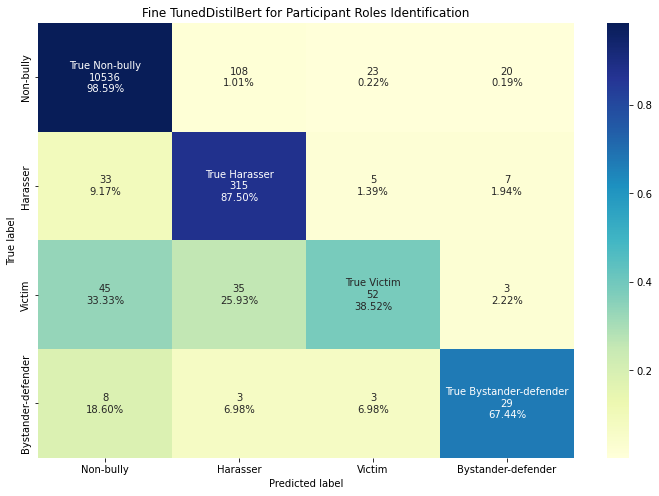

In [12]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-4775', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-9550/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-9550",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading w

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.67      0.84      0.75       360
           2       0.46      0.44      0.45       135
           3       0.63      0.63      0.63        43

    accuracy                           0.97     11225
   macro avg       0.69      0.72      0.70     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6897995625631497
Recall:  0.7227460545977964
F-measure:  0.703869936643523

Label 0: Non-bully
Precision:  0.9918913822364699
Recall:  0.9843735379432956
F-measure:  0.9881181608979477

Label 1: Harasser
Precision:  0.6748329621380846
Recall:  0.8416666666666667
F-measure:  0.7490729295426451

Label 2: Victim
Precision:  0.4645669291338583
Recall:  0.43703703703703706
F-measure:  0.450381679389313

Label 3: Bystander-defender
Precision:  0.627906976744186
Recall:  0.627906976744186
F-measure:  0.62790697674

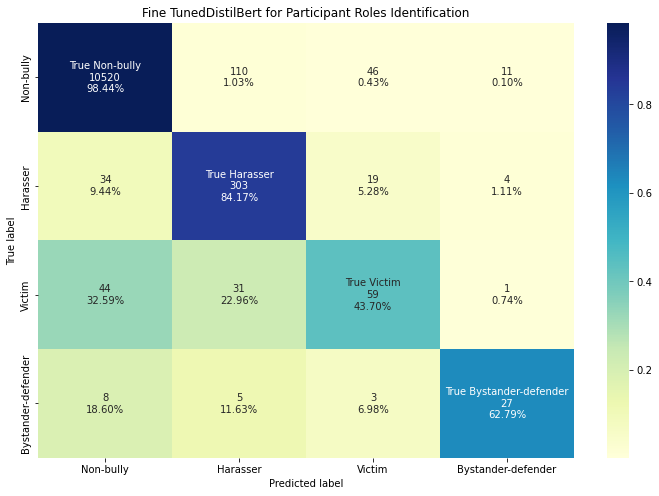

In [13]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-9550', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-14325/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-14325",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.64      0.89      0.74       360
           2       0.48      0.47      0.47       135
           3       0.69      0.51      0.59        43

    accuracy                           0.97     11225
   macro avg       0.70      0.71      0.70     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6982819873121827
Recall:  0.7113526610127159
F-measure:  0.6964077935494375

Label 0: Non-bully
Precision:  0.9928970546453263
Recall:  0.9810049592963414
F-measure:  0.9869151840346418

Label 1: Harasser
Precision:  0.6354581673306773
Recall:  0.8861111111111111
F-measure:  0.7401392111368911

Label 2: Victim
Precision:  0.4772727272727273
Recall:  0.4666666666666667
F-measure:  0.4719101123595506

Label 3: Bystander-defender
Precision:  0.6875
Recall:  0.5116279069767442
F-measure:  0.5866666666666667



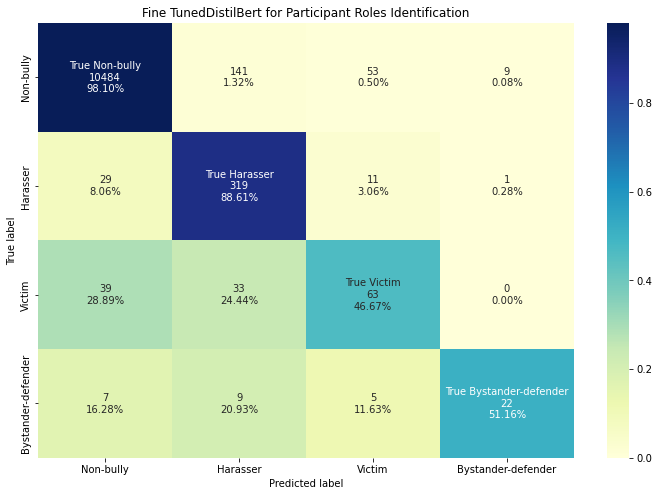

In [14]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-14325', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-19100/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-19100",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.70      0.84      0.76       360
           2       0.50      0.44      0.46       135
           3       0.59      0.63      0.61        43

    accuracy                           0.97     11225
   macro avg       0.69      0.72      0.71     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6930163242142452
Recall:  0.7230267694850425
F-measure:  0.7057124182896273

Label 0: Non-bully
Precision:  0.9911537737624694
Recall:  0.9854963974922804
F-measure:  0.9883169896307418

Label 1: Harasser
Precision:  0.6981566820276498
Recall:  0.8416666666666667
F-measure:  0.7632241813602015

Label 2: Victim
Precision:  0.4957983193277311
Recall:  0.43703703703703706
F-measure:  0.4645669291338583

Label 3: Bystander-defender
Precision:  0.5869565217391305
Recall:  0.627906976744186
F-measure:  0.60674157

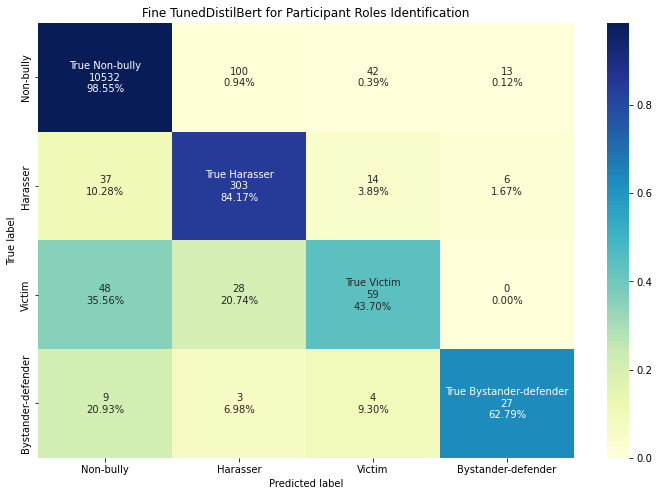

In [15]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-19100', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 5

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-23875/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-23875",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.67      0.83      0.74       360
           2       0.37      0.56      0.45       135
           3       0.55      0.60      0.58        43

    accuracy                           0.97     11225
   macro avg       0.65      0.74      0.69     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.64564942911166
Recall:  0.7440216942114624
F-measure:  0.6872641688474709

Label 0: Non-bully
Precision:  0.9930634739642722
Recall:  0.9779170955366333
F-measure:  0.9854320871246053

Label 1: Harasser
Precision:  0.6674107142857143
Recall:  0.8305555555555556
F-measure:  0.7400990099009901

Label 2: Victim
Precision:  0.36893203883495146
Recall:  0.562962962962963
F-measure:  0.4457478005865103

Label 3: Bystander-defender
Precision:  0.5531914893617021
Recall:  0.6046511627906976
F-measure:  0.5777777777

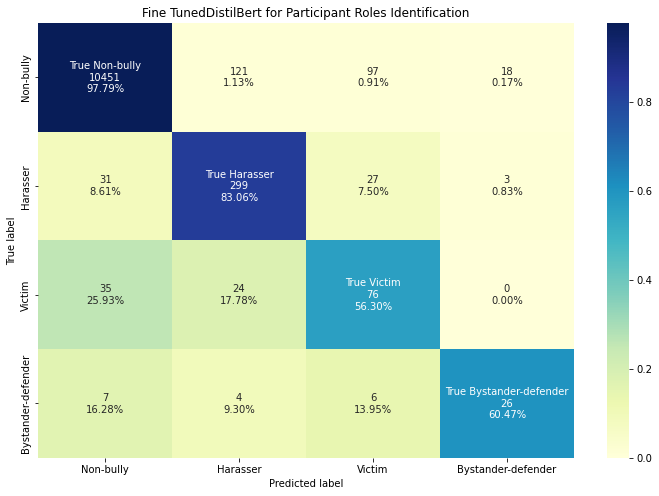

In [16]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-23875', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 6

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.63      0.84      0.72       360
           2       0.54      0.43      0.48       135
           3       0.57      0.65      0.61        43

    accuracy                           0.97     11225
   macro avg       0.68      0.73      0.70     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6844356924312556
Recall:  0.7262870839034472
F-measure:  0.6993730443877224

Label 0: Non-bully
Precision:  0.9916902738432484
Recall:  0.9826892486198184
F-measure:  0.987169243784368

Label 1: Harasser
Precision:  0.6325678496868476
Recall:  0.8416666666666667
F-measure:  0.7222884386174018

Label 2: Victim
Precision:  0.5420560747663551
Recall:  0.42962962962962964
F-measure:  0.47933884297520657

Label 3: Bystander-defender
Precision:  0.5714285714285714
Recall:  0.6511627906976745
F-measure:  0.6086956

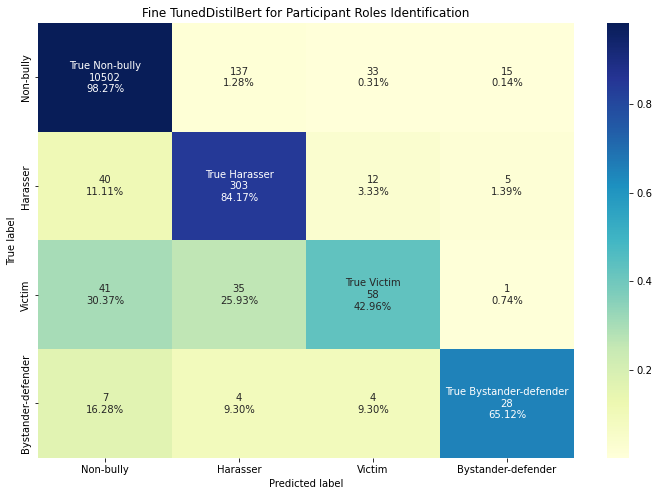

In [17]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-28650', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 7

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.64      0.85      0.73       360
           2       0.51      0.46      0.48       135
           3       0.61      0.58      0.60        43

    accuracy                           0.97     11225
   macro avg       0.69      0.72      0.70     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6896074521145235
Recall:  0.7183827499936128
F-measure:  0.6999993214322572

Label 0: Non-bully
Precision:  0.9920664903664526
Recall:  0.9828763918779826
F-measure:  0.9874500587544065

Label 1: Harasser
Precision:  0.6442105263157895
Recall:  0.85
F-measure:  0.732934131736527

Label 2: Victim
Precision:  0.512396694214876
Recall:  0.45925925925925926
F-measure:  0.48437499999999994

Label 3: Bystander-defender
Precision:  0.6097560975609756
Recall:  0.5813953488372093
F-measure:  0.5952380952380952



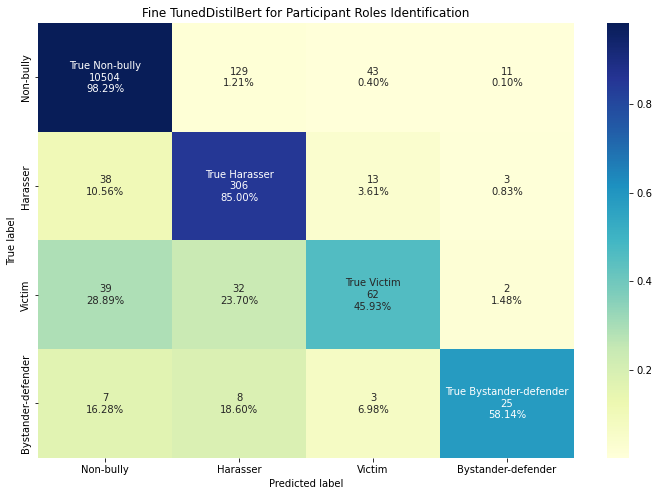

In [18]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-33425', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 8

loading configuration file content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200/config.json
Model config DistilBertConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.64      0.88      0.74       360
           2       0.53      0.44      0.48       135
           3       0.60      0.65      0.62        43

    accuracy                           0.97     11225
   macro avg       0.69      0.74      0.71     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6881774119872012
Recall:  0.736261732923198
F-measure:  0.7062045784393801

Label 0: Non-bully
Precision:  0.9925274309496784
Recall:  0.98184710395808
F-measure:  0.9871583799802437

Label 1: Harasser
Precision:  0.6376518218623481
Recall:  0.875
F-measure:  0.7377049180327869

Label 2: Victim
Precision:  0.5267857142857143
Recall:  0.43703703703703706
F-measure:  0.4777327935222673

Label 3: Bystander-defender
Precision:  0.5957446808510638
Recall:  0.6511627906976745
F-measure:  0.6222222222222222



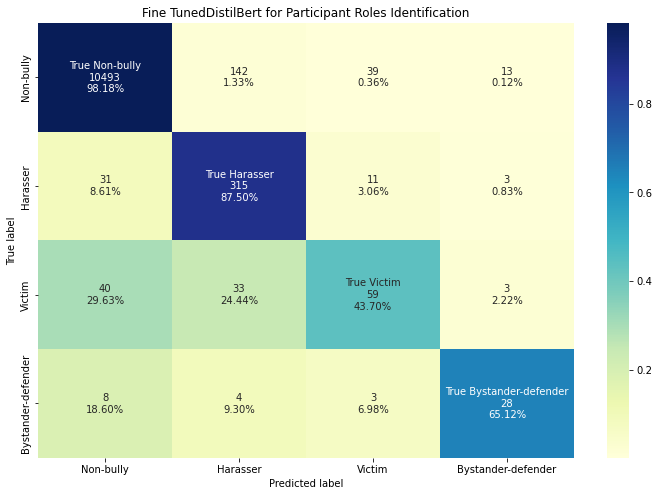

In [19]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='content/drive/MyDrive/output_DistilBert/holdout_test/checkpoint-38200', 
                        average_method='macro',
                        X_test=X_test)